In [1]:
import math
import matplotlib.pyplot as plt
import random

import torch
import numpy as np

import pennylane as qml
from pennylane import numpy as np
import sklearn
from sklearn.metrics import accuracy_score

import time
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cpu")

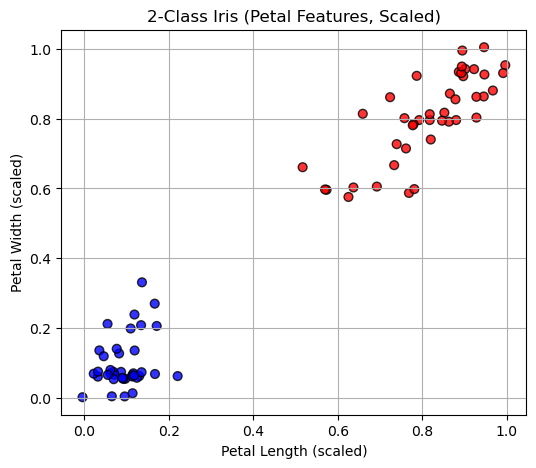

Min value in rescaled X_train: 0.0


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

dtype = torch.float32

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Keep only the first two classes (Setosa and Versicolor)
binary_mask = y < 2
X = X[binary_mask]
y = y[binary_mask]

# Use only petal length and petal width
X = X[:, [2, 3]]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Min-Max scaling to [0, 1]
min_vals = X_train.min(axis=0)
max_vals = X_train.max(axis=0)
X_train = 1*(X_train - min_vals) / (max_vals - min_vals)
X_test = 1*(X_test - min_vals) / (max_vals - min_vals)  # Apply same scaling to test data

# Plot the data
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,cmap='bwr',s=10,alpha=0.8)
jitter_scale = 0.01
X_plot = X_train + np.random.normal(scale=jitter_scale, size=X_train.shape)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=y_train,
    cmap='bwr',
    s=40,              # Larger points
    alpha=0.8,         # Semi-transparent
    edgecolors='k'     # Black outlines
)

plt.title("2-Class Iris (Petal Features, Scaled)")
plt.xlabel("Petal Length (scaled)")
plt.ylabel("Petal Width (scaled)")
plt.grid(True)
#plt.savefig(fname='IrisDataset.png',dpi=600)
plt.show()

# Convert test data to torch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training
train_data = [
    (torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.float32))
    for x, label in zip(X_train, y_train)
]
test_data = [
    (torch.tensor(x,dtype=torch.float32), torch.tensor(label, dtype=torch.float32))
    for x, label in zip(X_test, y_test)
]
train_loader = DataLoader(train_data, batch_size=25, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=25, shuffle=True, num_workers=4)



# Debug: print min value to verify scaling
print("Min value in rescaled X_train:", np.min(X_train))

In [3]:
n_qubits = 4
total_qubits = 8    ##### Change this to 8 if u want to use the ancillas
folds = 4
dev = qml.device("lightning.qubit", wires=total_qubits, c_dtype=np.complex64)

def strongly_entangling_layer(params, total_qubits=n_qubits):

    for i in range(total_qubits):
        qml.RY(params[i], wires=[i])
    for i in range(total_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[total_qubits - 1, 0])

def zz_featuremap(data_point):

    for i in range(len(data_point)):
        qml.Hadamard(wires=[i])
        qml.PhaseShift(2 * data_point[i], wires=[i])
    qml.CNOT(wires=[0,1])
    qml.PhaseShift(2 * (math.pi - data_point[0]) * (math.pi - data_point[1]), wires=1)
    qml.CNOT(wires=[0,1])

    
@qml.qnode(dev, interface="torch")
def circuit(data_point, params, folds=folds):
    qml.AmplitudeEmbedding(features=data_point+ 1e-7, wires=[0], pad_with=0., normalize=True)
    # zz_featuremap(data_point)
    # qml.AngleEmbedding(features=data_point, wires=range(2), rotation="X")

    for i in range(folds):
        strongly_entangling_layer(params[i], total_qubits=n_qubits)

    output = qml.expval(qml.PauliZ(wires=[0]))

    return output

In [4]:
class BatchLossModel(torch.nn.Module):

    def __init__(self, params):
        super().__init__()
        self.params = params

    def forward(self,x):
        outputs = torch.stack([circuit(x[i].cpu(), self.params.cpu()) for i in range(x.shape[0])])
        return outputs.to(device, dtype=dtype)

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.mps.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.mps.deterministc = True

def evaluate(model, data_loader):
    model.eval()
    batch_preds, batch_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:

            outputs = model(batch_x)
            pred = torch.sigmoid(outputs) > 0.5
            batch_preds.append(pred.cpu())
            batch_labels.append(batch_y.cpu())

    batch_preds = torch.cat(batch_preds)
    batch_labels = torch.cat(batch_labels)
    accuracy = accuracy_score(batch_labels.numpy(), batch_preds.numpy())
    return accuracy

In [6]:
seeds = [0,42,123,2024,999]
max_accuracy_per_seed = []


for seed in seeds:
    set_seed(seed)
    weights = torch.rand((folds, total_qubits), requires_grad=True, dtype=dtype, device=device)
    model = BatchLossModel(weights)
    opt = torch.optim.Adam([weights],lr=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    best_test_accuracy = 0.000001

    for epoch in range(20):

        model.train()
        for batch_x, batch_y in train_loader:
            opt.zero_grad()
            circuit_outputs = (model(batch_x) + 1)/2
            loss = loss_fn(circuit_outputs, batch_y)
            loss.backward()
            opt.step()
        
        test_acc = evaluate(model, test_loader)
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc

        print(f"seed {seed}: Epoch {epoch}; Test accuracy = {test_acc}")
    
    max_accuracy_per_seed.append(best_test_accuracy)

seed 0: Epoch 0; Test accuracy = 0.5
seed 0: Epoch 1; Test accuracy = 0.5
seed 0: Epoch 2; Test accuracy = 0.5
seed 0: Epoch 3; Test accuracy = 0.6
seed 0: Epoch 4; Test accuracy = 0.6
seed 0: Epoch 5; Test accuracy = 0.6
seed 0: Epoch 6; Test accuracy = 0.6
seed 0: Epoch 7; Test accuracy = 0.6
seed 0: Epoch 8; Test accuracy = 0.6
seed 0: Epoch 9; Test accuracy = 0.6
seed 0: Epoch 10; Test accuracy = 0.6
seed 0: Epoch 11; Test accuracy = 0.6
seed 0: Epoch 12; Test accuracy = 0.6
seed 0: Epoch 13; Test accuracy = 0.6
seed 0: Epoch 14; Test accuracy = 0.6
seed 0: Epoch 15; Test accuracy = 0.6
seed 0: Epoch 16; Test accuracy = 0.6
seed 0: Epoch 17; Test accuracy = 0.6
seed 0: Epoch 18; Test accuracy = 0.6
seed 0: Epoch 19; Test accuracy = 0.6
seed 42: Epoch 0; Test accuracy = 0.55
seed 42: Epoch 1; Test accuracy = 0.55
seed 42: Epoch 2; Test accuracy = 0.6
seed 42: Epoch 3; Test accuracy = 0.6
seed 42: Epoch 4; Test accuracy = 0.6
seed 42: Epoch 5; Test accuracy = 0.6
seed 42: Epoch 6; Te

In [7]:
print(f"Mean of Best Test Accuracies for diff seeds: {np.mean(max_accuracy_per_seed)}")

Mean of Best Test Accuracies for diff seeds: 0.6


In [8]:
print(f"Standard Deviation: {np.std(max_accuracy_per_seed)}")

Standard Deviation: 0.0


In [9]:
import json

results = {
    "seeds" : seeds,
    "max_accuracy_per_seed" : max_accuracy_per_seed,
    "mean_best_accuracy" : np.mean(max_accuracy_per_seed),
    "standard deviation" : np.std(max_accuracy_per_seed)
}

results["note"] = (
    "Amplitude Encoding - With Ancillas\n"
)

file_name = f"/Users/akashmalemath/Documents/master_work/qcbm_hiwi/vqc_iris/mean_testacc_diff_seeds/vqc_iris_diff_seeds_amplitudeenc_ancillas.json"
with open(file_name, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved results to {file_name}")

Saved results to /Users/akashmalemath/Documents/master_work/qcbm_hiwi/vqc_iris/mean_testacc_diff_seeds/vqc_iris_diff_seeds_amplitudeenc_ancillas.json
